In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Plots
using JLD2

In [23]:
function run_bp(N::Integer; generic::Bool=false,
        tol = 0.0)
    T = 10
    λ = 0.2
    ρ = 0.1
    γ = fill(0.05, N)

    sis = SIS(IndexedGraph(star_graph(N)), λ, ρ, T; γ)

    # set up MPBP computation
    bp_ = mpbp(sis)
    
    bp = if generic 
        mpbp(bp_.g, [GenericFactor.(wᵢ) for wᵢ in bp_.w], fill(2, N), T; ϕ=bp_.ϕ)
    else
        bp_
    end
    cb = CB_BP(bp, showprogress=false)
    svd_trunc = TruncBond(5)
    iterate!(bp; maxiter=1, svd_trunc, tol, cb)
#     reset!(bp)
    t = @timed begin
        iterate!(bp; maxiter=5, svd_trunc, tol, cb);
    end
    p_bp = means((x,i)->x-1, bp)
    return t, p_bp, bp
end

run_bp (generic function with 1 method)

In [59]:
using Unzip, Statistics

Ns = 2:50
nsamples = 10
p_rec = []
p_gen = []
out = map(Ns) do N
    println("Size $N")
    push!(p_rec, []); push!(p_gen, [])
    t = map(1:nsamples) do _
        t_recursive, pr = run_bp(N; generic=false)
        push!(p_rec[end], pr)
        tr = t_recursive.time
        tg = if N ≤ 6
            t_generic, pg = run_bp(N; generic=true)
            push!(p_gen[end], pg)
            t_generic.time
        else
            NaN
        end
        tr, tg 
    end |> unzip
    mean.(t), std.(t) ./ nsamples
end;

Size 2
Size 3
Size 4
Size 5
Size 6
Size 7
Size 8
Size 9
Size 10
Size 11
Size 12
Size 13
Size 14
Size 15
Size 16
Size 17
Size 18
Size 19
Size 20
Size 21
Size 22
Size 23
Size 24
Size 25
Size 26
Size 27
Size 28
Size 29
Size 30
Size 31
Size 32
Size 33
Size 34
Size 35
Size 36
Size 37
Size 38
Size 39
Size 40
Size 41
Size 42
Size 43
Size 44
Size 45
Size 46
Size 47
Size 48
Size 49
Size 50


In [60]:
t_rec_avg = [x[1][1] for x in out]
t_rec_std = [x[2][1] for x in out]
t_gen_avg = [x[1][2] for x in out]
t_gen_std = [x[2][2] for x in out];

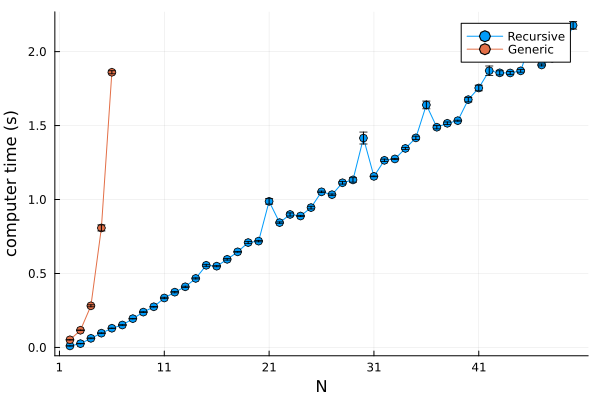

In [61]:
pl = plot(Ns, t_rec_avg, m=:o, label="Recursive", yerr=t_rec_std)
plot!(pl, Ns, t_gen_avg, m=:o, label="Generic", yerr=t_gen_std)
plot(pl, ylabel="computer time (s)", xlabel="N", legend=:topright,
    xticks=1:10:Ns[end])

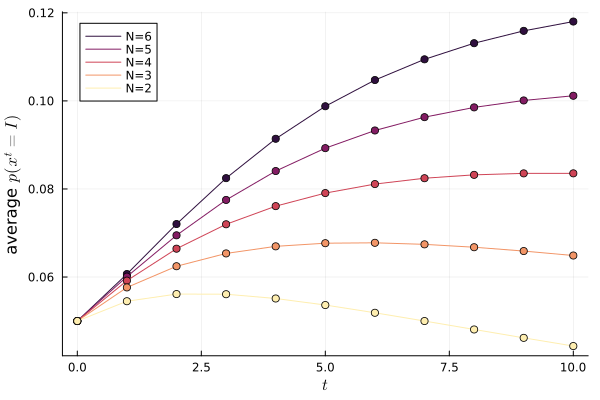

In [94]:
using ColorSchemes, LaTeXStrings
idx = eachindex(Ns)[1:5]
cg = cgrad(:matter, length(idx), categorical=true)

pl = plot()
for i in eachindex(idx) |> reverse
    N = Ns[idx[i]]
    pr = mean(mean(p_rec[idx[i]]))
    plot!(pl, eachindex(pr) .- 1, pr, label="N=$N", c=cg[i]) 
    pg = mean(mean(p_gen[idx[i]]))
    plot!(pl, eachindex(pg) .- 1, pg, label="", c=cg[i], st=:scatter)
end
plot(pl, xlabel=L"t", ylabel="average "*(L"p(x^t=I)"))

In [95]:
jldsave("plot_data/star_graph.jld2"; Ns, t_rec_avg, t_rec_std, t_gen_avg, t_gen_std, p_gen, p_rec);